In [7]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import shap


In [3]:
df = pd.read_csv("customer_churn_telecom.csv")

In [4]:
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [5]:
# 1. Data Overview
df.info()
print("Missing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [9]:
# 2. Drop Irrelevant Columns
df.drop(columns=['state', 'area code', 'phone number'], inplace=True)

In [10]:
# 3. Encode Categorical Variables
df['international plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})
df['churn'] = df['churn'].astype(int)  # Convert churn to binary (1 for True, 0 for False)


In [11]:
# 4. Separate Features and Target Variable
X = df.drop('churn', axis=1)
y = df['churn']

In [12]:
# 5. Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# 6. Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# 7. Initialize and Train Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
results = {}

In [16]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    results[model_name] = {'Accuracy': accuracy, 'ROC AUC': roc_auc}

In [17]:
# Display Model Performance
results_df = pd.DataFrame(results).T
print("Model Performance:\n", results_df)

Model Performance:
                    Accuracy   ROC AUC
Random Forest      0.947526  0.939440
Gradient Boosting  0.949025  0.925533


In [18]:
# 8. Feature Importance with SHAP (for Gradient Boosting)
explainer = shap.TreeExplainer(models['Gradient Boosting'])
shap_values = explainer.shap_values(X_test)


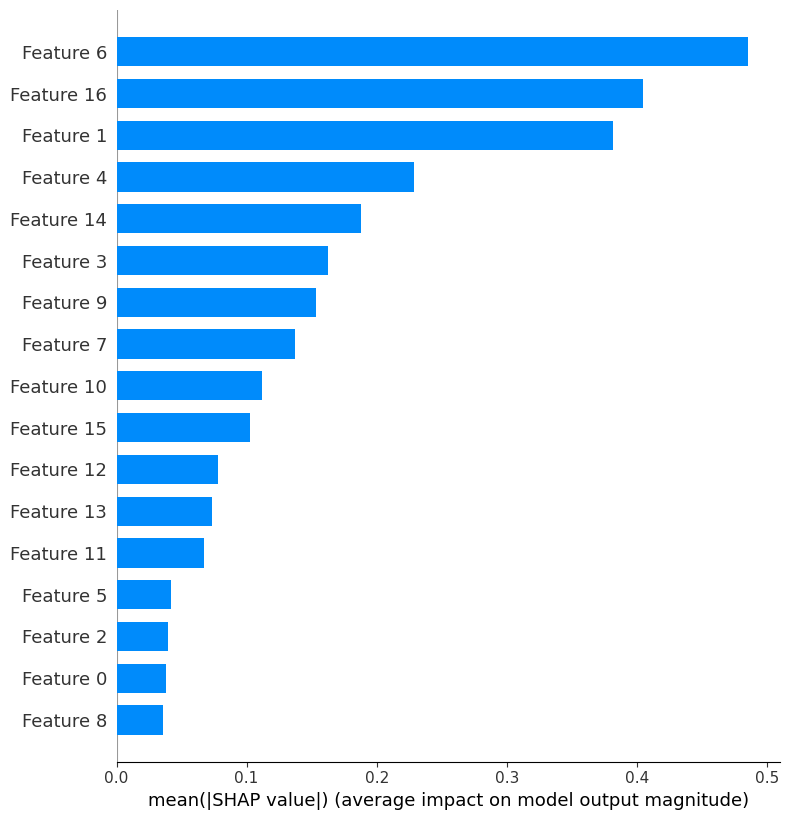

In [19]:
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [20]:
# 9. Insights for Retention Strategy
high_risk = df[(df['churn'] == 1) & (df['account length'] < df['account length'].median())]
print(f"High-risk customers (low tenure, high churn risk): {high_risk.shape[0]}")

High-risk customers (low tenure, high churn risk): 234
